# Importing necessary libraries

In [1]:

import numpy as np
import skimage.morphology as morpho  
from skimage import img_as_float
import matplotlib.pyplot as plt
import cv2
import torch

# Exploring Inpainting Techniques with a Black and White Image

##  Creating a Half Black and Half White Canvas


In [2]:
# Create a black canvas
# Define the size of the canvas (256x256 pixels)
canvas_size = (256, 256)
# Initialize the canvas with zeros (black) with the defined size
canvas = np.zeros((canvas_size[0], canvas_size[1], 3), dtype=np.uint8)

# Define rectangle parameters
# Calculate the half width to divide the canvas
half_width = canvas_size[1] // 2
# Define the rectangles (left half and right half)
rectangle_1 = ((0, 0), (half_width, canvas_size[0]))  # Left half, black
rectangle_2 = ((half_width, 0), (half_width, canvas_size[0]))  # Right half, white

# Draw rectangles on the canvas
# Black rectangle on the left half
cv2.rectangle(canvas, rectangle_1[0], (rectangle_1[0][0] + rectangle_1[1][0], rectangle_1[0][1] + rectangle_1[1][1]), (0, 0, 0), -1)
# White rectangle on the right half
cv2.rectangle(canvas, rectangle_2[0], (rectangle_2[0][0] + rectangle_2[1][0], rectangle_2[0][1] + rectangle_2[1][1]), (255, 255, 255), -1)

# Save the image to the file system
cv2.imwrite("half_bw.png", canvas)


True

## Loading \& Displaying an Image

In [3]:
# Define the function to load and display an image
def loadImagebis(src):
    # Read the image from the specified source path
    img = cv2.imread(src, 1)
    # Convert the color space from BGR to RGB to display correctly with matplotlib
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Create a figure with a specified size for displaying the image
    plt.figure(figsize=(5,5))
    # Display the RGB image without interpolation to preserve original appearance
    plt.imshow(rgb, interpolation='nearest')
    # Hide the axis to focus on the image itself
    plt.axis('off')
    # Show the image in a plot
    plt.show()


In [4]:


def view_data(img, figsize=(5, 5)):
    """
    Display an image.

    Parameters:
        img (numpy.ndarray): The image data. It can be grayscale or RGB.
        figsize (tuple): The size of the figure (default is (5, 5)).

    Returns:
        None
    """
    plt.figure(figsize=figsize)
    
    # If it's a binary image (e.g., border matrix), convert it to RGB for visualization
    if img.ndim == 2:  # Check if the image is grayscale
        img = np.stack((img, img, img), axis=-1)  # Convert to RGB by duplicating the channel
    elif img.shape[2] == 1:  # Check if the image has only one channel
        img = np.repeat(img, 3, axis=2)  # Duplicate the single channel to create an RGB image
        
    plt.imshow(img)
    plt.axis('off')
    plt.show()


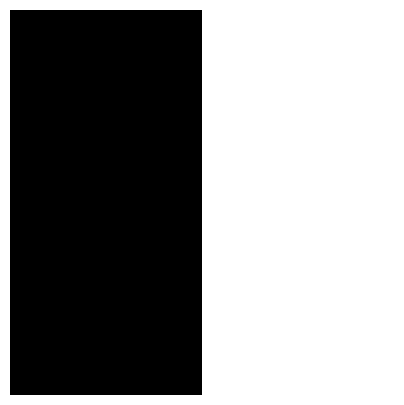

In [5]:

loadImagebis("half_bw.png")

## Rectangular Mask Manipulation

### Mask creation

In [6]:
def mask(img, x1, x2, y1, y2):
    """
    Takes an image and four coordinates, produces a mask with the same size as the image.

    Parameters:
        img (numpy.ndarray): Input image.
        x1, x2, y1, y2 (int): Coordinates defining the rectangle to be masked.

    Returns:
        numpy.ndarray: Mask with the specified region set to 0.
    """
    height, width = img.shape[:2]
    
    # Ensure coordinates are within image bounds
    x1 = max(0, min(x1, width - 1))
    x2 = max(0, min(x2, width))
    y1 = max(0, min(y1, height - 1))
    y2 = max(0, min(y2, height))

    # Create a mask with ones
    mask = np.ones((height, width), dtype=int)

    # Set the specified rectangle region to 0
    mask[y1:y2, x1:x2] = 0

    return mask


### Mask reading

In [7]:
def read_mask(mask):
    """
    Writes the provided mask to a PNG file named "mask.png".

    Parameters:
        mask (numpy.ndarray): The mask to be saved as an image.

    Returns:
        None
    """
    cv2.imwrite("mask.png", mask)


### Removing the masked area from the input image

In [8]:
def delete_zone(img, mask):
    """
    Remove the masked area from the input image.

    Parameters:
        img (numpy.ndarray): The input image.
        mask (numpy.ndarray): The mask indicating the area to be removed.

    Returns:
        numpy.ndarray: The image with the masked area removed.
    """
    img = img_as_float(img)
    new_img = np.copy(img)
    new_img[mask == 0] = 0
    return new_img

In [9]:
img = cv2.imread("half_bw.png")
mask_1=mask(img, 80, 150, 30+35, 88+35)
new_img = delete_zone(img, mask_1)


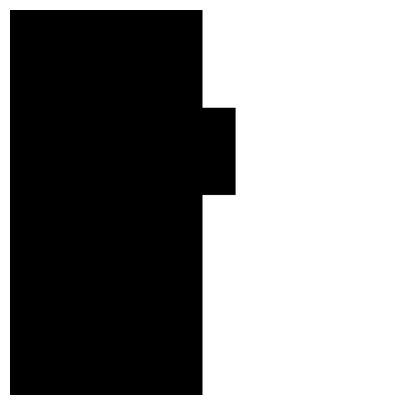

In [10]:
view_data(new_img)

### Borders of the mask

In [11]:

def init_bord_m(mask):
    """
    Initialize the border of a mask.

    Parameters:
        mask (numpy.ndarray): Input binary mask.

    Returns:
        list: List of border pixel coordinates.
    """
    # Apply morphological operation to find the borders
    bords = mask - morpho.erosion(mask)
    
    # Find the coordinates of the border pixels
    border_coords = np.argwhere(bords == 1)
    
    # Convert coordinates to a list of tuples
    L = [(i, j) for i, j in border_coords]
    
    return L
bord=init_bord_m(mask_1)

In [12]:

def display_mask_with_border(masked_image, border_coordinates, figsize=(8, 6)):
    """
    Display the image with the mask overlaid and the border highlighted.

    Parameters:
        masked_image (numpy.ndarray): The image with the mask overlaid.
        border_coordinates (list): List of border pixel coordinates.
        figsize (tuple): Size of the figure. Default is (8, 6).

    Returns:
        None
    """
    # Create a new figure
    plt.figure(figsize=figsize)
    
    # Display the image with the mask overlaid
    plt.imshow(masked_image)
    
    # Highlight the border pixels
    for coord in border_coordinates:
        plt.plot(coord[1], coord[0], 'yo', markersize=2)  # Yellow border pixels
    
    # Turn off axis
    plt.axis('off')
    
    # Show the plot
    plt.show()


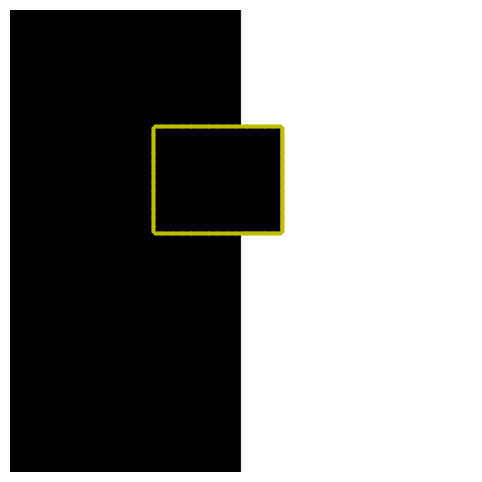

In [13]:
display_mask_with_border(new_img, bord)

# Exemplar-based Inpainting

## Patch manipulation

In [ ]:
def get_patch(image,p,patch_size):
    """
    Returns a patch centered on p
    """
    r = patch_size//2
    clip = np.array(image[p[0]-r:p[0]+r+1,p[1]-r:p[1]+r+1])
    return clip 


In [ ]:
def similarity(patch1, patch2, maskpatch):
    """
    Calculate the similarity between two patches based on a mask.

    Args:
    patch1 (numpy.ndarray): The first patch.
    patch2 (numpy.ndarray): The second patch.
    maskpatch (numpy.ndarray): The mask indicating the regions to consider for similarity.

    Returns:
    float: The similarity between the patches.
    """
    # Initialize the similarity distance
    d = 0
    
    # Iterate over each color channel
    for i in range(3): 
        # Calculate the squared difference between corresponding pixel values,
        # weighted by the mask
        d += np.sum(maskpatch * (patch1[:, :, i] - patch2[:, :, i]) ** 2)
    
    return d


## Computing patch priorities

The priority of a patch influences the order in which it is filled during the inpainting process. It is calculated based on two main factors: the confidence term and the data term. The priority function \(P(p)\) for a patch \(p\) is given by the product of these two terms:


$$P(p) = C(p) \times D(p)$$






### Confidence Term $C(p)$

The confidence term $C(p)$ measures how much of the patch area is already filled with reliable information. It is defined as the average of the confidence values of all pixels in the patch that are already filled:

$$C(p) = \frac{\sum_{i \in \psi_p} C(i)}{|\psi_p|}$$

where $|\psi_p|$ is the area of the patch and $C(i)$ is the confidence value at pixel $i$.

In [51]:


def confidence(mask,patch_size):
    """
    Compute the confidence map based on the provided mask.

    Parameters:
        mask (numpy.ndarray): The mask to be used for the computation.

    Returns:
        numpy.ndarray: The confidence map.
    """
    n, m = mask.shape
    c=np.zeros(mask.shape)
    for k in range(n):
        for l in range(m):
            patch = get_patch(mask,(k,l),patch_size)
            c[k,l]=np.sum(patch)/(patch.shape[0]*patch.shape[1])
    return c


### Data Term $D(p)$

The data term $D(p)$ encourages the selection of patches with more significant edge information, thus favoring the continuity of edges into the region being inpainted. It can be related to the gradient of the image at the patch border:

$$D(p) = | \nabla I_p \cdot n_p |$$

where $\nabla I_p$ is the gradient of the image at the patch boundary and $n_p$ is the unit normal to the boundary of the patch.

In [56]:
def gradient_I(image, mask, bordure,patch_size):
    """
    Compute the gradient I(p) for all p in delta(\Omega).

    Parameters:
        image (numpy.ndarray): The input image.
        mask (numpy.ndarray): The binary mask indicating the filled and unfilled regions.
        bordure (list): List of border pixel coordinates.

    Returns:
        list: List containing the x and y components of the gradient I(p) for each point in the border.
    """
    h, w = image.shape[:2]
    c = image.copy()
    c = c.astype(np.float64)
    c[mask == 0] = np.NaN  # Mask the outside of the mask
    
    # Separate color channels
    c_r, c_g, c_b = img_as_float(c[:, :, 0]), img_as_float(c[:, :, 1]), img_as_float(c[:, :, 2])
   
    fgradx, fgrady = np.zeros((h, w)), np.zeros((h, w))
    
    for point in bordure:
        # Extract patches for each channel outside the loop
        patches_r = get_patch(c_r, point, patch_size)
        patches_g = get_patch(c_g, point,patch_size)
        patches_b = get_patch(c_b, point,patch_size)
        
        # Compute gradients for each channel
        gradients_r = np.nan_to_num(np.gradient(patches_r))
        gradients_g = np.nan_to_num(np.gradient(patches_g))
        gradients_b = np.nan_to_num(np.gradient(patches_b))
        
        # Compute norme for each channel
        norme_r = np.sqrt(gradients_r[0]**2 + gradients_r[1]**2)
        norme_g = np.sqrt(gradients_g[0]**2 + gradients_g[1]**2)
        norme_b = np.sqrt(gradients_b[0]**2 + gradients_b[1]**2)
        
        # Compute maximum norme across channels
        norme = np.maximum(np.maximum(norme_r, norme_g), norme_b)
        
        # Find the maximum norme index for each patch
        max_patch = np.unravel_index(norme.argmax(), norme.shape)
        
        # Assign gradients based on the maximum norme index
        fgradx[point[0], point[1]] = gradients_r[0][max_patch]
        fgrady[point[0], point[1]] = gradients_r[1][max_patch]
    
    return [fgradx, fgrady]

I_p = gradient_I(img, mask_1, bord, patch_size=8)

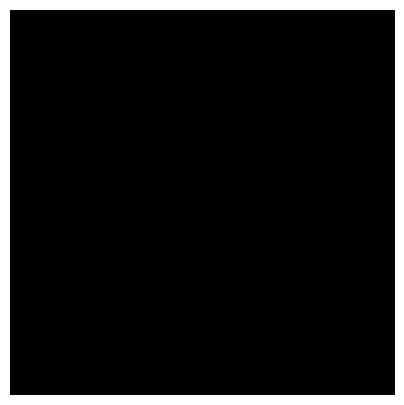

In [58]:
view_data(I_p[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


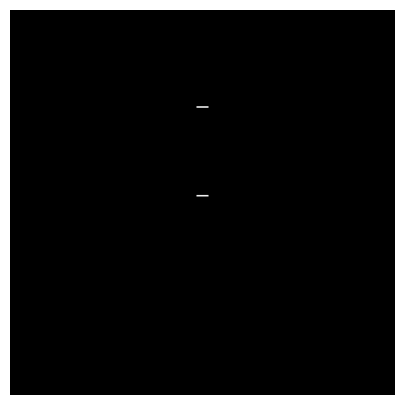

In [59]:
view_data(I_p[1])

In [23]:

def normal_vect(image, mask, bord,patch_size):
    """
    Compute the normal vectors at each point on the boundary of the mask.

    Parameters:
        image (numpy.ndarray): The input image.
        mask (numpy.ndarray): The binary mask indicating the filled and unfilled regions.
        bord (list): List of border pixel coordinates.

    Returns:
        tuple: Tuple containing the x and y components of the normal vectors for each point in the border.
    """
    h, w = mask.shape[:2]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    coordx, coordy = torch.zeros((h, w), dtype=torch.float, device=device), torch.zeros((h, w), dtype=torch.float, device=device)
    
    for p in bord:
        i, j = p
        patch = get_patch(mask,(i,j),patch_size)
        
        grad = len(patch)*len(patch[0])*np.nan_to_num(np.array(np.gradient(patch)))
        grad = torch.tensor(grad, dtype=torch.float, device=device)
        gradX, gradY = grad[0], grad[1]
        
        # Compute the central index of the patch
        centerX, centerY = patch.shape[0] // 2, patch.shape[1] // 2
        
        # Compute the x and y components of the normal vector
        coordx[i, j] = gradX[centerX, centerY]
        coordy[i, j] = gradY[centerX, centerY]
    
    return coordy.cpu().numpy(), coordx.cpu().numpy()


In [25]:
n=normal_vect(img,mask_1,init_bord_m(mask_1),patch_size = 8)

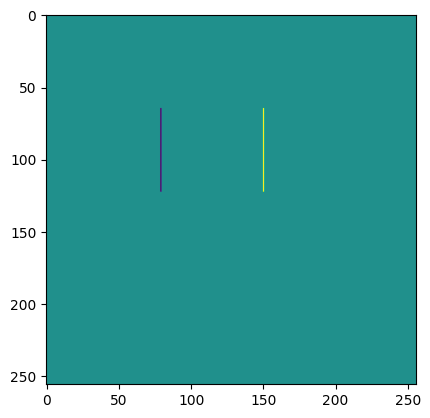

In [26]:
plt.imshow(n[0])

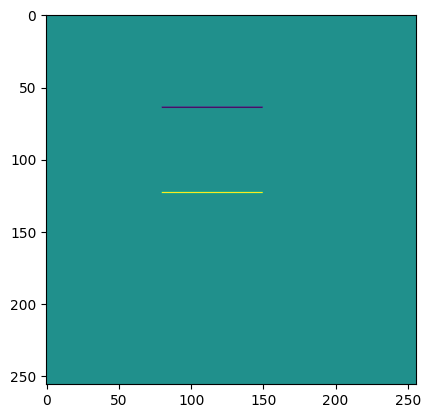

In [27]:
plt.imshow(n[1])

### The priority term $P(p)$

In [24]:
def P(image, mask, bordure,patch_size):
    """
    Computes P for points on the border.

    Parameters:
        image (numpy.ndarray): The input image.
        mask (numpy.ndarray): The binary mask indicating the filled and unfilled regions.
        bordure (list): List of border pixel coordinates.

    Returns:
        numpy.ndarray: The computed P values for each point on the border.
    """
    h, w = mask.shape[:2]
    P = np.zeros((h, w))
    C = confidence(mask,patch_size)
    I = gradient_I(image, mask, bordure,patch_size)
    N = normal_vect(image, mask, bordure,patch_size)

    # Extracting i and j coordinates from bordure
    i_coords, j_coords = zip(*bordure)

    # Compute P_values for all coordinates in bordure
    P_values = np.abs(I[0][i_coords, j_coords] * N[0][i_coords, j_coords] +
                      I[1][i_coords, j_coords] * N[1][i_coords, j_coords]) / 255 * C[i_coords, j_coords]

    # Assign computed values to P array at corresponding coordinates
    P[i_coords, j_coords] = P_values

    return P


In [25]:
def maxP(image, mask, bordure, patch_size):
    """
    Finds the point with the maximum value of P.

    Args:
    image (numpy.ndarray): The input image.
    mask (numpy.ndarray): The mask indicating the inpainted area.
    bordure (list): List of points representing the border of the inpainted area.
    patch_size (int): The size of the patch for inpainting.

    Returns:
    tuple: The coordinates (i, j) of the point with the maximum value of P.
    """
    # Calculate the values of P
    p = P(image, mask, bordure, patch_size)
    
    # Initialize variables to store the maximum value and its coordinates
    maximum = p[bordure[0]]
    argmax = bordure[0]
    
    # Iterate over each point in the border
    for point in bordure:
        i, j = point
        # Update the maximum value and its coordinates if a larger value is found
        if p[i][j] >= maximum:
            maximum = p[i][j]
            argmax = point
    
    return argmax


C:\Users\oumai\AppData\Local\Temp\ipykernel_22380\1058935569.py:16: RuntimeWarning: invalid value encountered in scalar divide
  c[k,l]=np.sum(patch)/(patch.shape[0]*patch.shape[1])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


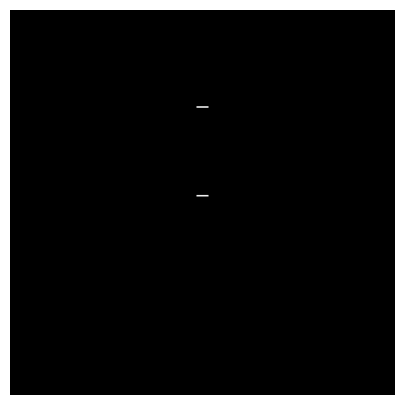

In [30]:
P_img = P(img, mask_1, bord)
view_data(P_img)

## The Core Iteration of the Algorithm

In [26]:
def iterate(image, firstmask, patch_size):
    """
    Perform iterative inpainting algorithm.

    Args:
    image (numpy.ndarray): The input image.
    firstmask (numpy.ndarray): The initial mask indicating the damaged area.
    patch_size (int): The size of the patch for inpainting.

    Returns:
    numpy.ndarray: The inpainted image.
    """
    # Create a copy of the initial mask
    mask = np.copy(firstmask)
    
    # Initialize the border points
    frt = init_bord_m(mask)
    
    # Create a new image by removing the damaged area
    new_image = delete_zone(image, mask)
    
    # Initialize variables
    K = 0
    ps = patch_size // 2
    
    # Iterate until there are no more border points
    while len(frt) > 0:
        # Find the point with the maximum value of P
        p_point = maxP(new_image, mask, frt, patch_size)
        
        # Get the patch centered at the maximum P point
        p_patch = get_patch(new_image, p_point, patch_size)
        
        # Initialize the minimum similarity distance
        d = similarity(get_patch(new_image, (ps, ps), patch_size), p_patch, get_patch(mask, (ps, ps), patch_size))
        
        # Initialize the chosen coordinates
        chosenX, chosenY = p_point
        
        # Get the mask patch
        maskpatch = get_patch(mask, (chosenX, chosenY), patch_size)
        
        # Looking for a patch that is closest to the content of the incomplete patch
        for x in range(ps, new_image.shape[0] - ps):
            for y in range(ps, new_image.shape[1] - ps):
                potential = True
                firstpatch = get_patch(firstmask, (x, y), patch_size)
                for i in range(patch_size):
                    for j in range(patch_size):
                        if firstpatch[i, j] == 0:
                            potential = False
                if potential:
                    testPatch = get_patch(new_image, (x, y), patch_size)
                    dtest = similarity(p_patch, testPatch, maskpatch)
                    if dtest < d:
                        d = dtest
                        new_patch = np.copy(testPatch)
        
        # Filling
        for i in range(-ps, ps + 1):
            for j in range(-ps, ps + 1):
                if mask[chosenX + i, chosenY + j] == 0:
                    new_image[chosenX + i, chosenY + j] = new_patch[ps + i, ps + j]
                    mask[chosenX + i, chosenY + j] = 1
        
        # Update the border points
        frt = init_bord_m(mask)
        
        
        # Display progress every 10 iterations
        if K % 10 == 0:
            print(f"Iteration {K} completed")
            view_data(new_image)
        
        K += 1
    
    # Return the inpainted image
    return new_image


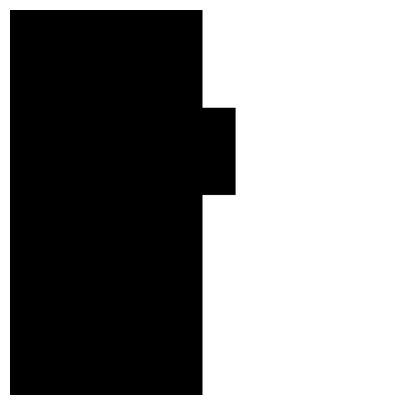

C:\Users\oumai\AppData\Local\Temp\ipykernel_22380\1058935569.py:16: RuntimeWarning: invalid value encountered in scalar divide
  c[k,l]=np.sum(patch)/(patch.shape[0]*patch.shape[1])


iteration 0


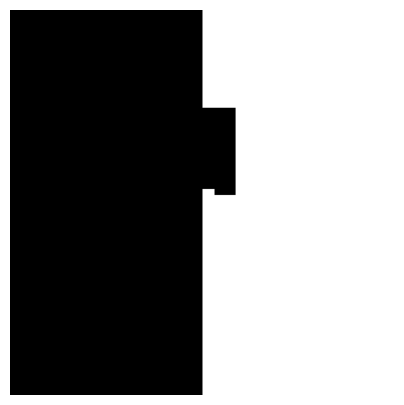

iteration 10


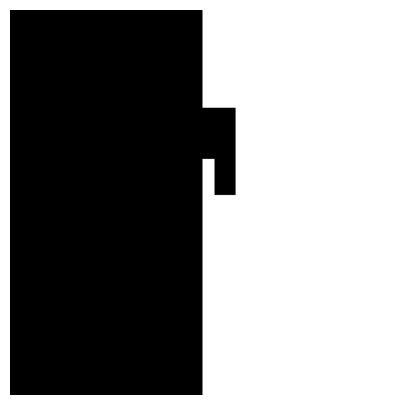

iteration 20


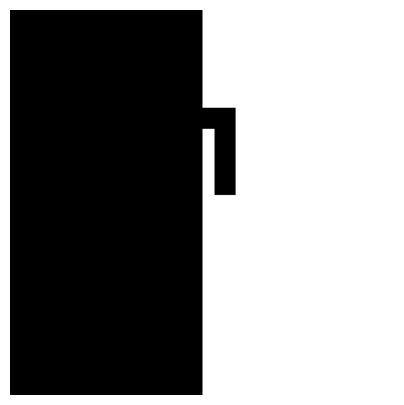

iteration 30


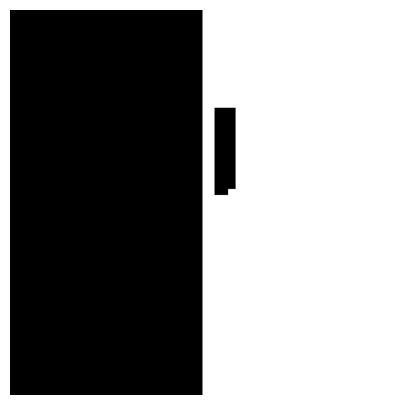

iteration 40


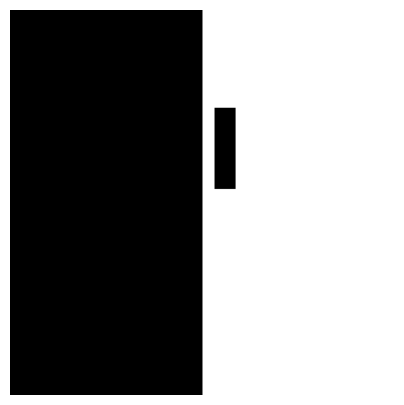

iteration 50


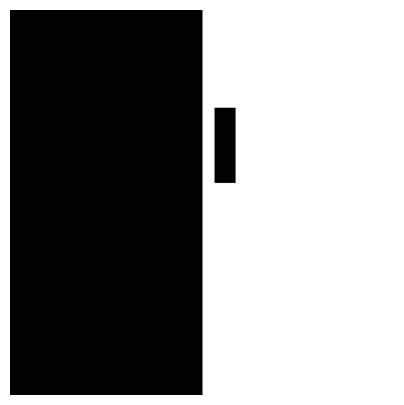

iteration 60


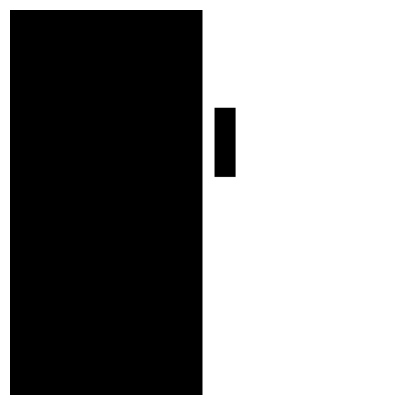

iteration 70


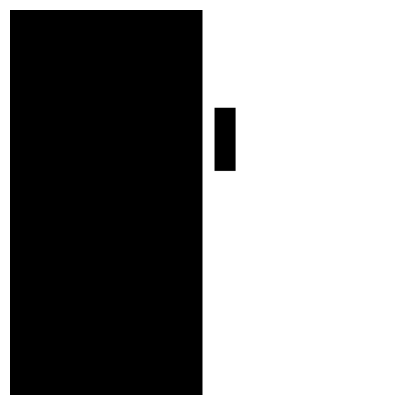

iteration 80


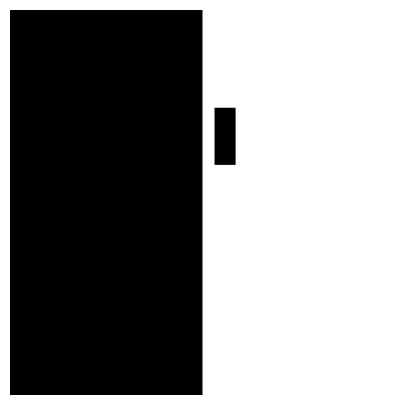

iteration 90


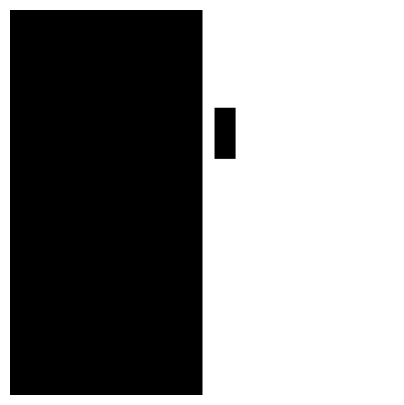

iteration 100


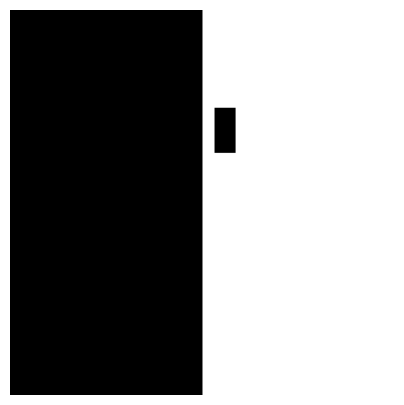

iteration 110


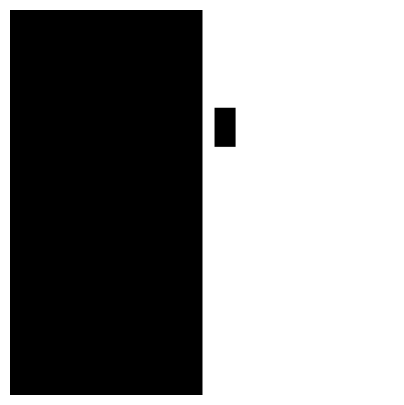

iteration 120


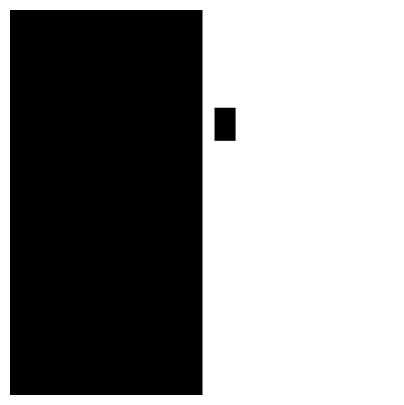

iteration 130


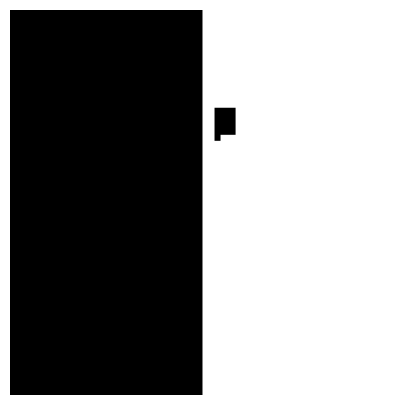

iteration 140


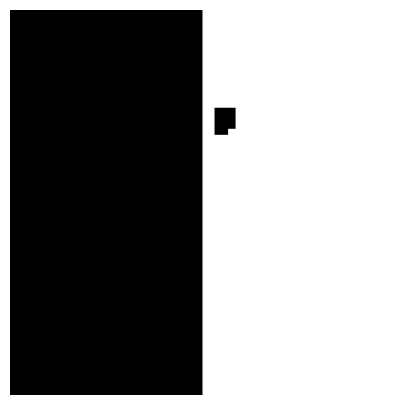

iteration 150


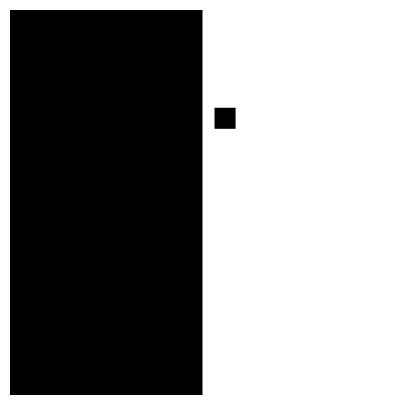

iteration 160


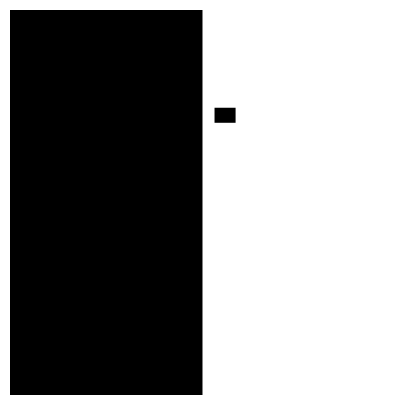

iteration 170


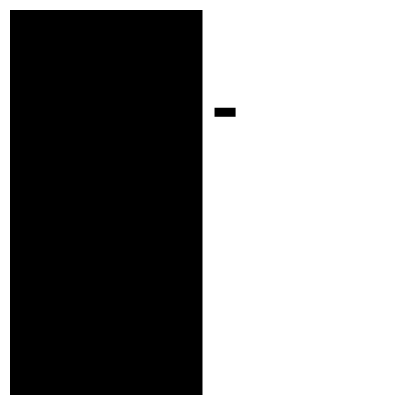

iteration 180


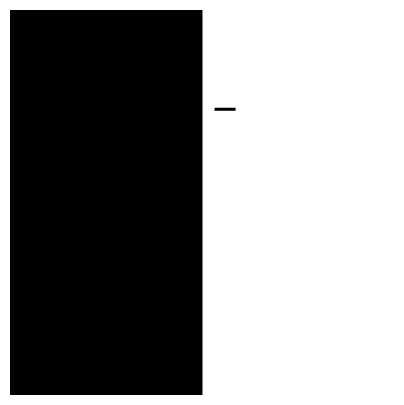

iteration 190


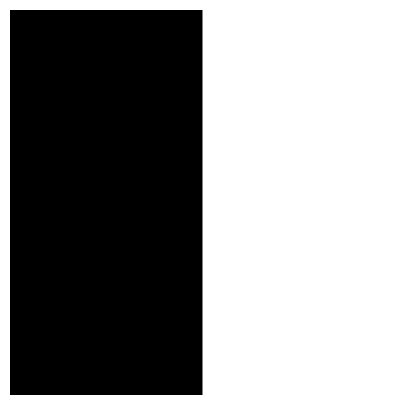

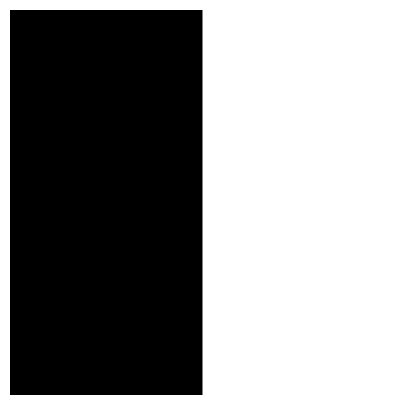

In [32]:
iterate(img, mask_1,patch_size = 8)


# A Simple RGB Image

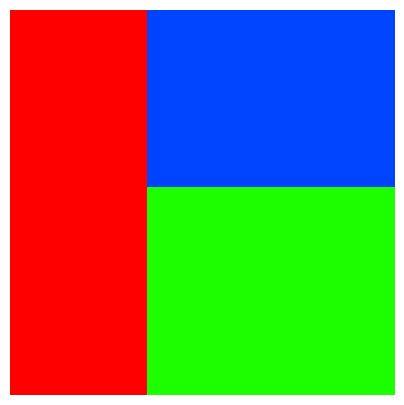

In [33]:
loadImagebis("RGB.png")

In [34]:
img_rgb = cv2.imread("RGB.png")

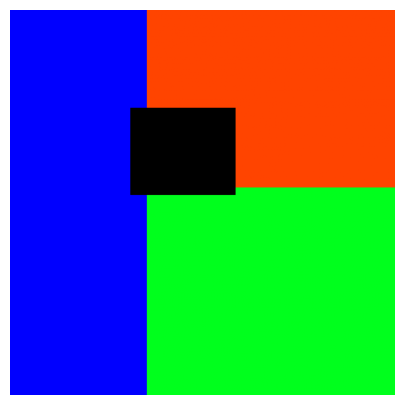

C:\Users\oumai\AppData\Local\Temp\ipykernel_22380\1058935569.py:16: RuntimeWarning: invalid value encountered in scalar divide
  c[k,l]=np.sum(patch)/(patch.shape[0]*patch.shape[1])


iteration 0


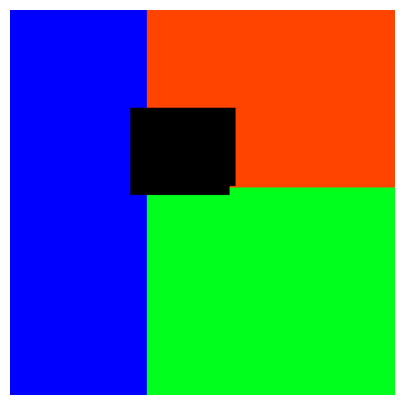

iteration 10


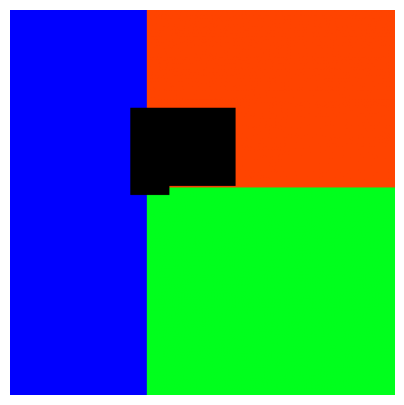

iteration 20


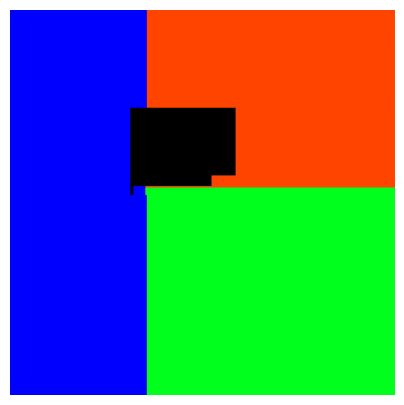

iteration 30


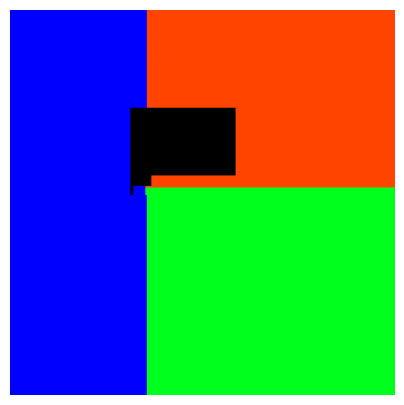

iteration 40


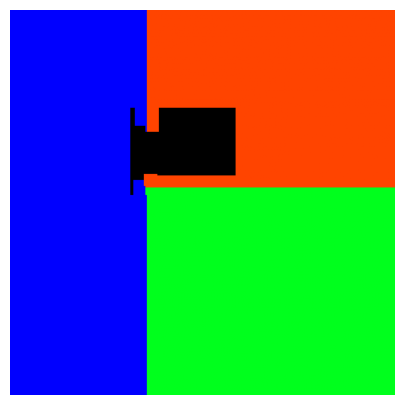

iteration 50


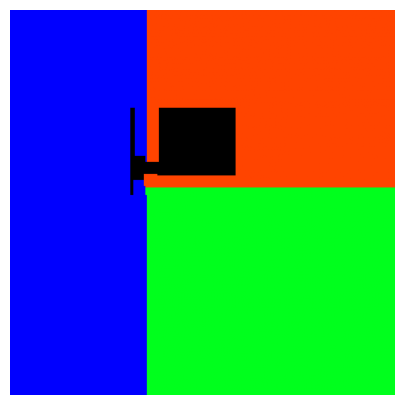

iteration 60


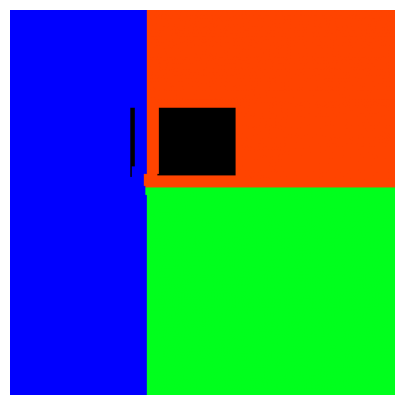

iteration 70


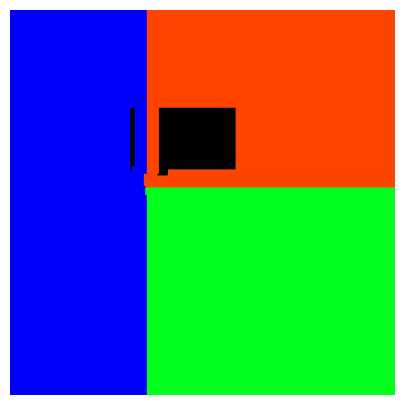

iteration 80


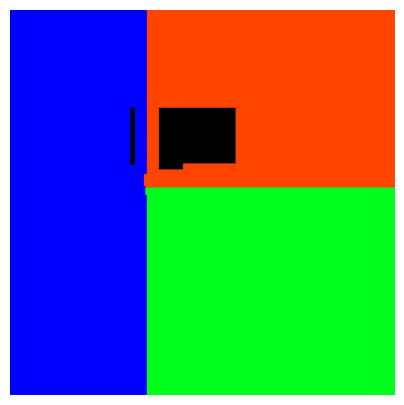

iteration 90


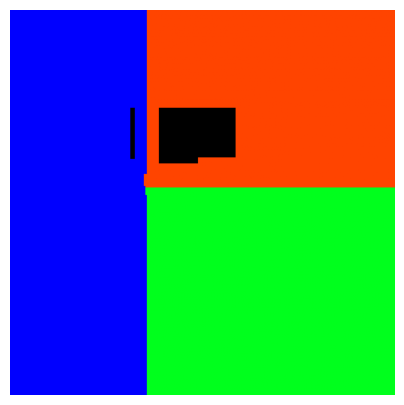

iteration 100


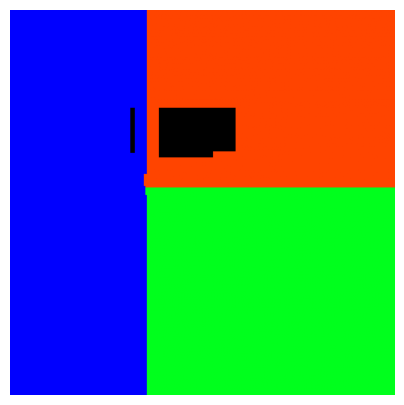

iteration 110


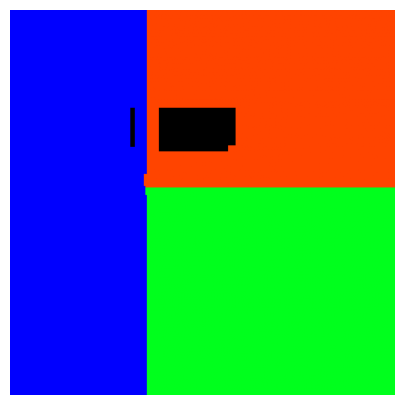

iteration 120


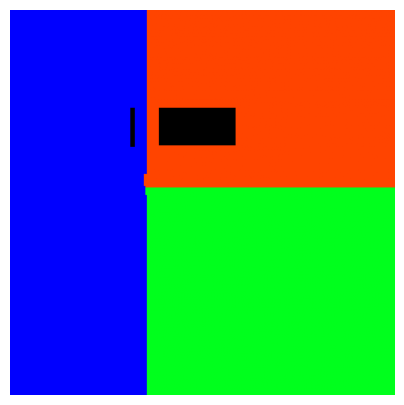

iteration 130


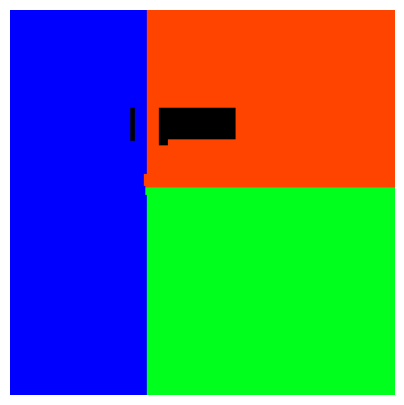

iteration 140


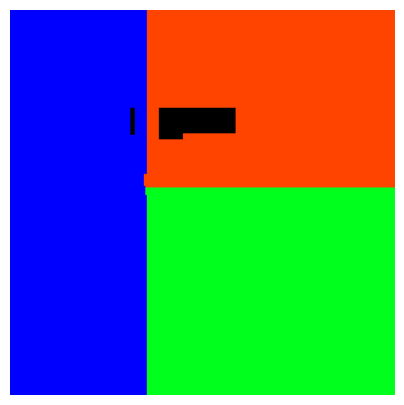

iteration 150


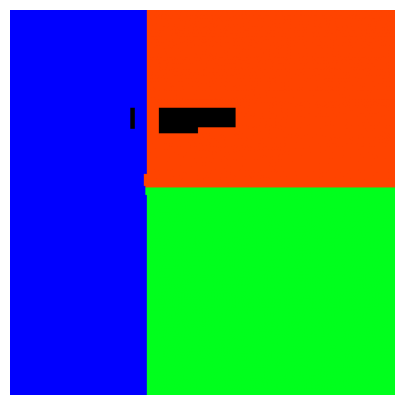

iteration 160


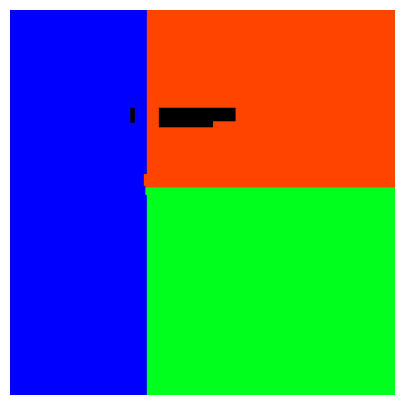

iteration 170


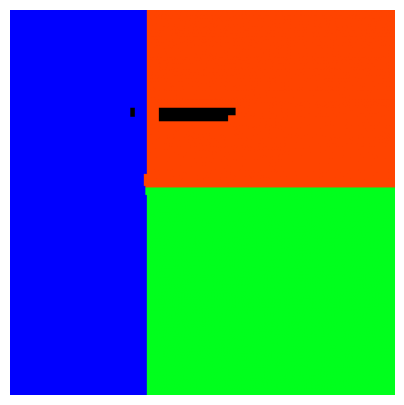

iteration 180


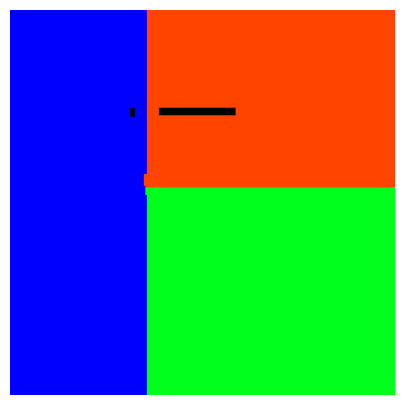

iteration 190


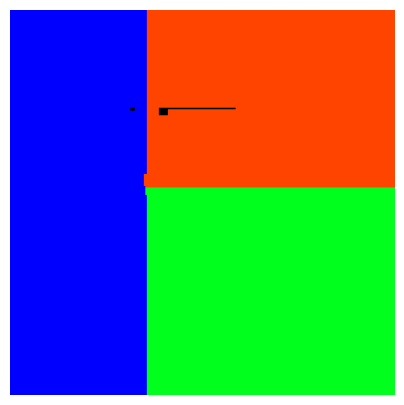

iteration 200


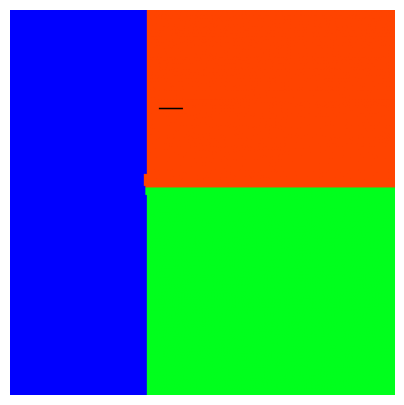

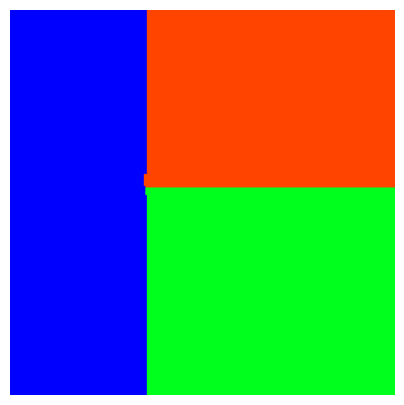

In [35]:
iterate(img_rgb, mask_1, patch_size=8)
